In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------------------
# River generation and related functions
# -----------------------------------------
def generate_river_custom(city_size):
    """
    Function to generate a river (flows from left to right).
    1. Start point: middle of the left edge with ± city_size/5 variation.
    2. x-coordinate divisions: x0=0, x1=city_size/4, x2=city_size/3, x3=2/3*city_size, x4=3/4*city_size, x5=city_size.
       - At x1, flip a coin: if tails, apply slope 0.5 in the x1~x2 interval 
         (if start point is above city_size/2 then descending, otherwise ascending).
       - At x3, flip a coin: if tails, apply slope 0.5 in the x3~x4 interval 
         (here another coin flip decides ascending/descending).
    3. River width is chosen uniformly between city_size/10 and city_size/5.
    """
    # Flow direction: left→right
    # Start point: (0, y0)
    y0 = city_size/2 + np.random.uniform(-city_size/5, city_size/5)
    
    x0 = 0
    x1 = city_size/4
    x2 = city_size/3
    x3 = 2 * city_size/3
    x4 = 3 * city_size/4
    x5 = city_size
    
    # Coin flip at x1
    coin1 = np.random.random() < 0.5  # True: skip slope, False: apply slope
    if not coin1:
        slope1 = -0.5 if y0 > city_size/2 else 0.5
        y2 = y0 + slope1 * (x2 - x1)
    else:
        y2 = y0
    # x2 ~ x3: constant
    # Coin flip at x3
    coin2 = np.random.random() < 0.5
    if not coin2:
        coin3 = np.random.random() < 0.5  # True: ascending, False: descending
        slope2 = 0.5 if coin3 else -0.5
        y4 = y2 + slope2 * (x4 - x3)
    else:
        y4 = y2
    # x4 ~ x5: constant
    xs = np.array([x0, x1, x2, x3, x4, x5])
    ys = np.array([y0, y0, y2, y2, y4, y4])
    
    river_width = np.random.uniform(city_size/10, city_size/5)
    return xs, ys, river_width

def river_y_at(x, xs, ys):
    """Return the river's y-coordinate at a given x (linear interpolation)."""
    return np.interp(x, xs, ys)

# -----------------------------------------
# Function to check distance from river when placing nodes
# -----------------------------------------
def is_valid_position(pos, xs, ys, city_size, margin=None):
    """
    pos: (x, y) coordinate
    margin: minimum required distance from the river (defaults to city_size/10)
    Returns: True if pos is at least margin away from the river.
    """
    if margin is None:
        margin = city_size/10
    x, y = pos
    river_y = river_y_at(x, xs, ys)
    # Simple vertical distance check (for more precision, compute minimum distance to the curve)
    return abs(y - river_y) >= margin

def get_valid_seed(city_size, xs, ys, margin=None):
    """Return a random seed position within the city that is at least margin away from the river."""
    if margin is None:
        margin = city_size/10
    while True:
        candidate = (np.random.uniform(0, city_size), np.random.uniform(0, city_size))
        if is_valid_position(candidate, xs, ys, city_size, margin):
            return candidate

# -----------------------------------------
# City and node generation (adds river exclusion to existing cluster logic)
# -----------------------------------------
def generate_city(num_nodes, city_size=10, cluster_node_num=3):
    """
    Function to generate a city layout.
    1. Generate the river first.
    2. Assign node types:
       - If num_nodes == 4: one each of R, I, C, O.
       - If num_nodes >= 5: one each of R, I, C, O, H, 
         and the rest randomly chosen from R, I, C, O, S.
    3. Cluster placement (R, I, C, O are clustered; S uses Lloyd's algorithm for uniform distribution).
       - Cluster seeds are sampled at least margin away from the river.
    4. H node placed at a corner far from the river.
    5. S nodes initially random, then relaxed with Lloyd’s algorithm.
    """
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4.")
    
    # 1. Generate the river first
    river_xs, river_ys, river_width = generate_river_custom(city_size)
    
    # 2. Assign node types
    if num_nodes == 4:
        types = ['R', 'I', 'C', 'O']
    else:
        types = ['R', 'I', 'C', 'O', 'H']
        remaining = num_nodes - 5
        for _ in range(remaining):
            types.append(np.random.choice(['R', 'I', 'C', 'O', 'S']))
        np.random.shuffle(types)
    
    total_nodes = len(types)
    positions = [None] * total_nodes
    
    # 3. Cluster placement for R, I, C, O
    cluster_info = {}
    cluster_of_node = {}
    cluster_counter = 0
    for t in ['R', 'I', 'C', 'O']:
        idx_list = [i for i, ty in enumerate(types) if ty == t]
        if not idx_list:
            continue
        np.random.shuffle(idx_list)
        for i in range(0, len(idx_list), cluster_node_num):
            cluster_nodes = idx_list[i:i+cluster_node_num]
            seed = get_valid_seed(city_size, river_xs, river_ys)
            cluster_info[cluster_counter] = {
                'type': t,
                'indices': cluster_nodes,
                'seed': seed,
                'center': cluster_nodes[0]
            }
            for node in cluster_nodes:
                offset = np.random.uniform(-city_size/20, city_size/20, size=2)
                pos_candidate = (seed[0] + offset[0], seed[1] + offset[1])
                # If candidate is too close to river, resample at seed
                if not is_valid_position(pos_candidate, river_xs, river_ys, city_size):
                    pos_candidate = get_valid_seed(city_size, river_xs, river_ys)
                positions[node] = pos_candidate
                cluster_of_node[node] = cluster_counter
            cluster_counter += 1

    # 4. Place S nodes: random then Lloyd's relaxation
    s_indices = [i for i, ty in enumerate(types) if ty == 'S']
    if s_indices:
        s_positions = []
        for _ in s_indices:
            # Ensure at least margin distance from river
            pos_valid = get_valid_seed(city_size, river_xs, river_ys)
            s_positions.append(pos_valid)
        s_positions = np.array(s_positions)
        # Apply Lloyd's relaxation
        s_positions_relaxed = lloyd_relaxation(s_positions, (0, city_size, 0, city_size), iterations=20, sample_points=2000)
        for idx, pos in zip(s_indices, s_positions_relaxed):
            positions[idx] = tuple(pos)
    
    # 5. Place H node: choose a corner position farthest from cluster seeds
    h_indices = [i for i, ty in enumerate(types) if ty == 'H']
    if h_indices:
        h_index = h_indices[0]
        candidates = [(0,0), (0, city_size), (city_size, 0), (city_size, city_size)]
        valid_candidates = [cand for cand in candidates if is_valid_position(cand, river_xs, river_ys, city_size)]
        if valid_candidates:
            best_candidate = None
            best_min_dist = -1
            for cand in valid_candidates:
                min_dist = np.inf
                for info in cluster_info.values():
                    d = np.sqrt((cand[0]-info['seed'][0])**2 + (cand[1]-info['seed'][1])**2)
                    if d < min_dist:
                        min_dist = d
                if min_dist > best_min_dist:
                    best_min_dist = min_dist
                    best_candidate = cand
            positions[h_index] = best_candidate
        else:
            positions[h_index] = get_valid_seed(city_size, river_xs, river_ys)
    
    # Fallback: randomly place any unset nodes away from river
    for i in range(total_nodes):
        if positions[i] is None:
            positions[i] = get_valid_seed(city_size, river_xs, river_ys)
    
    nodes = [[types[i], positions[i]] for i in range(total_nodes)]
    
    # 6. Edge creation (same MST, external links, S links logic)
    edges = []
    # (A) Intra-cluster MST for each cluster
    for cid, info in cluster_info.items():
        cluster_nodes = info['indices']
        if len(cluster_nodes) > 1:
            G_cluster = nx.Graph()
            for u in cluster_nodes:
                G_cluster.add_node(u)
            for i in range(len(cluster_nodes)):
                for j in range(i+1, len(cluster_nodes)):
                    u = cluster_nodes[i]
                    v = cluster_nodes[j]
                    pos_u = positions[u]
                    pos_v = positions[v]
                    dist = np.sqrt((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)
                    G_cluster.add_edge(u, v, weight=dist)
            T = nx.minimum_spanning_tree(G_cluster)
            for (u, v) in T.edges():
                edges.append([u, v])
    
    # (B) External connections from cluster centers
    cluster_centers = [info['center'] for info in cluster_info.values()]
    external_candidates = cluster_centers.copy()
    if h_indices:
        external_candidates.append(h_indices[0])
    
    def weighted_external_num():
        r = np.random.random()
        if r < 0.5:
            return 1
        elif r < 0.8:
            return 2
        else:
            return 3
    
    for center in cluster_centers:
        num_ext = weighted_external_num()
        candidates = [n for n in external_candidates if n != center]
        center_pos = positions[center]
        candidates.sort(key=lambda n: np.sqrt((positions[n][0]-center_pos[0])**2 + (positions[n][1]-center_pos[1])**2))
        count = 0
        for cand in candidates:
            if [center, cand] in edges or [cand, center] in edges:
                continue
            edges.append([center, cand])
            count += 1
            if count >= num_ext:
                break
    
    # (C) Additional connections for S nodes
    for s in s_indices:
        other_s = [n for n in s_indices if n != s]
        if other_s:
            other_s.sort(key=lambda n: np.sqrt((positions[n][0]-positions[s][0])**2 + (positions[n][1]-positions[s][1])**2))
            nearest = other_s[0]
            if [s, nearest] not in edges and [nearest, s] not in edges:
                edges.append([s, nearest])
        for _ in range(2):
            candidates = [n for n in external_candidates if n != s and ([s, n] not in edges and [n, s] not in edges)]
            if not candidates:
                break
            candidates.sort(key=lambda n: np.sqrt((positions[n][0]-positions[s][0])**2 + (positions[n][1]-positions[s][1])**2))
            chosen = candidates[0]
            edges.append([s, chosen])
            if np.random.random() < 0.5:
                break

    # (D) If H node is isolated, connect it to the nearest S node
    if h_indices:
        h_node = h_indices[0]
        h_connected = any(h_node in edge for edge in edges)
        if not h_connected and s_indices:
            s_candidates = s_indices.copy()
            s_candidates.sort(key=lambda n: np.sqrt((positions[n][0]-positions[h_node][0])**2 + (positions[n][1]-positions[h_node][1])**2))
            nearest = s_candidates[0]
            edges.append([h_node, nearest])
    
    # (E) Ensure graph connectivity: add shortest edges between components if needed
    G_temp = nx.Graph()
    for i in range(total_nodes):
        G_temp.add_node(i)
    for u, v in edges:
        pos_u = positions[u]
        pos_v = positions[v]
        dist = np.sqrt((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)
        G_temp.add_edge(u, v, weight=dist)
    candidate_nodes = set(cluster_centers)
    for i, ty in enumerate(types):
        if ty in ['S', 'H']:
            candidate_nodes.add(i)
    while not nx.is_connected(G_temp):
        comps = list(nx.connected_components(G_temp))
        best_pair = None
        best_dist = np.inf
        for i, comp1 in enumerate(comps):
            for comp2 in comps[i+1:]:
                for n1 in comp1:
                    if n1 in candidate_nodes:
                        for n2 in comp2:
                            if n2 in candidate_nodes:
                                d = np.sqrt((positions[n1][0]-positions[n2][0])**2 + (positions[n1][1]-positions[n2][1])**2)
                                if d < best_dist:
                                    best_dist = d
                                    best_pair = (n1, n2)
        if best_pair is not None:
            u, v = best_pair
            edges.append([u, v])
            G_temp.add_edge(u, v, weight=best_dist)
        else:
            break

    # Return nodes, edges, and river information together
    return nodes, edges, (river_xs, river_ys, river_width)

# -----------------------------------------
# Lloyd's algorithm for uniform S node placement
# -----------------------------------------
def lloyd_relaxation(points, bbox, iterations=10, sample_points=1000):
    pts = points.copy()
    xmin, xmax, ymin, ymax = bbox
    for _ in range(iterations):
        samples = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(sample_points, 2))
        dists = np.linalg.norm(samples[:, None] - pts[None, :], axis=2)
        assignments = np.argmin(dists, axis=1)
        new_pts = np.zeros_like(pts)
        for i in range(pts.shape[0]):
            assigned = samples[assignments == i]
            if len(assigned) > 0:
                new_pts[i] = assigned.mean(axis=0)
            else:
                new_pts[i] = pts[i]
        pts = new_pts
    return pts

# -----------------------------------------
# Visualization function (includes river)
# -----------------------------------------
def plot_city_with_river(nodes, edges, river_info, city_size=10):
    xs, ys, river_width = river_info
    G = nx.Graph()
    pos = {}
    node_color_map = []
    color_mapping = {'R':'lightgreen', 'I':'yellow', 'C':'blue', 'O':'skyblue', 'S':'darkgray', 'H':'orange'}
    
    for i, (t, p) in enumerate(nodes):
        G.add_node(i)
        pos[i] = p
        node_color_map.append(color_mapping.get(t, 'black'))
    for u, v in edges:
        G.add_edge(u, v)
    
    plt.figure(figsize=(6,6))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_color_map, edge_color='gray', font_size=10)
    
    # Draw the river with width taken into account
    plt.plot(xs, ys, color='cadetblue', linewidth=river_width * 5, alpha=0.6)
    plt.xlim(-1, city_size+1)
    plt.ylim(-1, city_size+1)
    plt.title("City Map")
    plt.axis('on')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
    plt.show()

def add_edge(edges, start, end):
    """Add an edge (start, end) to edges list if not already present."""
    if isinstance(start, int) and isinstance(end, int):
        if [start, end] not in edges:
            edges.append([start,end])
    else:
        raise Exception('type error')
    return edges

def remove_edges(edges, start, end):
    """Remove an edge (start, end) from edges list if it exists."""
    if [start, end] in edges:
        edges.remove([start, end])
    elif [end, start] in edges:
        edges.remove([end, start])
    else:
        print('Cannot find that element')
    return edges

def rel_position_change(nodes, idx, dx, dy):
    """Change node position relative by (dx, dy)."""
    x_old, y_old = nodes[idx][1]
    nodes[idx][1] = (x_old + dx, y_old + dy)
    return nodes

def abs_position_change(nodes, idx, x, y):
    """Set node position to absolute coordinates (x, y)."""
    nodes[idx][1] = (x, y)
    return nodes


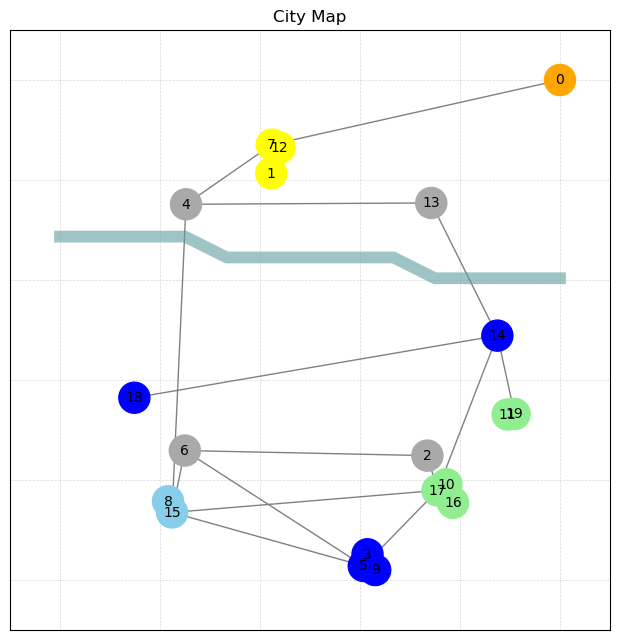

In [8]:
# test
np.random.seed(4)
city_size = 10
nodes, edges, river_info = generate_city(num_nodes=20, city_size=city_size, cluster_node_num=3)
plot_city_with_river(nodes, edges, river_info, city_size)


In [9]:
#edges = add_edge(edges, 2, 13)

#edges = remove_edges(edges, 4, 15)

#plot_city_with_river(nodes, edges, river_info, city_size)

In [10]:
river_info

(array([ 0.        ,  2.5       ,  3.33333333,  6.66666667,  7.5       ,
        10.        ]),
 array([6.86811936, 6.86811936, 6.45145269, 6.45145269, 6.03478602,
        6.03478602]),
 1.6977288245972708)

In [11]:
edges

[[17, 10],
 [16, 10],
 [19, 11],
 [7, 12],
 [1, 12],
 [5, 9],
 [5, 3],
 [14, 18],
 [15, 8],
 [17, 5],
 [19, 14],
 [7, 0],
 [5, 15],
 [14, 17],
 [15, 17],
 [2, 6],
 [2, 17],
 [4, 13],
 [4, 7],
 [4, 15],
 [6, 15],
 [6, 5],
 [13, 14]]

In [12]:
nodes

[['H', (10, 10)],
 ['I', (4.223045930723182, 8.133055524074585)],
 ['S', (7.347431312432605, 2.487777306985127)],
 ['C', (6.150197949952396, 0.5143284708729113)],
 ['S', (2.520195705347686, 7.514763482890908)],
 ['C', (6.07570983324487, 0.2798649074985111)],
 ['S', (2.4967688463490383, 2.588938003437716)],
 ['I', (4.234997018090638, 8.706548609726829)],
 ['O', (2.159876921190187, 1.5756594265030603)],
 ['C', (6.30339313793281, 0.19921226024762595)],
 ['R', (7.728790533843798, 1.914669944475406)],
 ['R', (8.952805775178767, 3.3109812889024712)],
 ['I', (4.390359483685025, 8.647324670077575)],
 ['S', (7.425446333108923, 7.540682393370534)],
 ['C', (8.747214362032699, 4.887620020791682)],
 ['O', (2.2417594565113883, 1.3508981561887161)],
 ['R', (7.860716750817584, 1.5434187490726914)],
 ['R', (7.549625439488781, 1.7922721597382427)],
 ['C', (1.4872683943405696, 3.645531753257558)],
 ['R', (9.092568733580197, 3.319982286450228)]]

you should copy these, and use these at 01_graph_preprocessing.ipynb